Image classification model using a neural network on the CIFAR-10 dataset. we will use transfer learning with TensorFlow and a pre-trained neural network to classify images from the CIFAR-10 dataset into 10 distinct categories. Each section will cover steps such as data preprocessing, model architecture selection, and performance evaluation.


In [13]:
# Install necessary libraries
!pip install tensorflow tensorflow_hub tensorflow_datasets


Before starting, installed necessary libraries. Used TensorFlow for neural network operations, TensorFlow Hub for pre-trained model access, and TensorFlow Datasets to load CIFAR-10 directly

In [7]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("cifar10", with_info=True, as_supervised=True)
train_ds, test_ds = dataset['train'], dataset['test']

train_ds = train_ds.take(1000)  # Use 1,000 samples for faster training
test_ds = test_ds.take(500)

# Display dataset information
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learni

The CIFAR-10 dataset contains 60,000 color images of 10 different classes, with each image sized at 32x32 pixels. The dataset is split into 1000 training images and 500 test images.

In [8]:
import tensorflow as tf
IMG_SIZE = (224, 224)  # Adjusted to match MobileNetV2 expected input size

def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Resize to MobileNetV2 input size
    image /= 255.0  # Normalize pixel values to [0, 1]
    return image, label

train_ds = train_ds.map(preprocess_image).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


To work effectively with a pre-trained model, resized each image to 224x224 pixels, the input size required for MobileNetV2, which will use in this project. Additionally, normalizing the images by scaling pixel values between 0 and 1 helps the model learn more efficiently.

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

# Define the feature extractor from TensorFlow Hub
feature_extractor_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
    trainable=False
)

# Use a Lambda layer with an explicit output_shape argument
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Lambda(lambda img: feature_extractor_layer(img), output_shape=(1280,))(inputs)
outputs = layers.Dense(10, activation='softmax')(x)
model = models.Model(inputs, outputs)


Used MobileNetV2, a lightweight neural network trained on the large ImageNet dataset, which has learned useful image features. This model’s architecture is efficient yet powerful, making it suitable for CIFAR-10 classification. We’ll use the MobileNetV2 feature extractor layer, followed by a fully connected layer that outputs 10 probabilities, one for each class in CIFAR-10. We’ll freeze the feature extractor layer, meaning it won’t be trained further, which reduces computation and helps prevent overfitting.



In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


To compile the model, used the Adam optimizer, known for its adaptive learning rate that balances convergence and learning efficiency. Also use the sparse_categorical_crossentropy loss function, suitable for multi-class classification with integer labels. This setup helps the model learn how to distinguish between the 10 classes effectively.

In [11]:
history = model.fit(train_ds, epochs=3, validation_data=test_ds)


Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.2208 - loss: 2.2818 - val_accuracy: 0.5960 - val_loss: 1.2552
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6867 - loss: 1.0057 - val_accuracy: 0.6940 - val_loss: 0.9202
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7849 - loss: 0.7111 - val_accuracy: 0.7260 - val_loss: 0.8245


Training the model will involve 3 epochs, or complete passes over the dataset. Although more epochs can sometimes improve performance, we’ll keep it moderate to avoid overfitting and to observe initial model behavior on CIFAR-10. Validation on the test dataset during each epoch helps monitor model performance, allowing us to check if it generalizes well to unseen data.

In [12]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7217 - loss: 0.8534
Test Accuracy: 0.73


Once trained, we evaluate the model on the test dataset, where accuracy measures how well the model can classify unseen images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


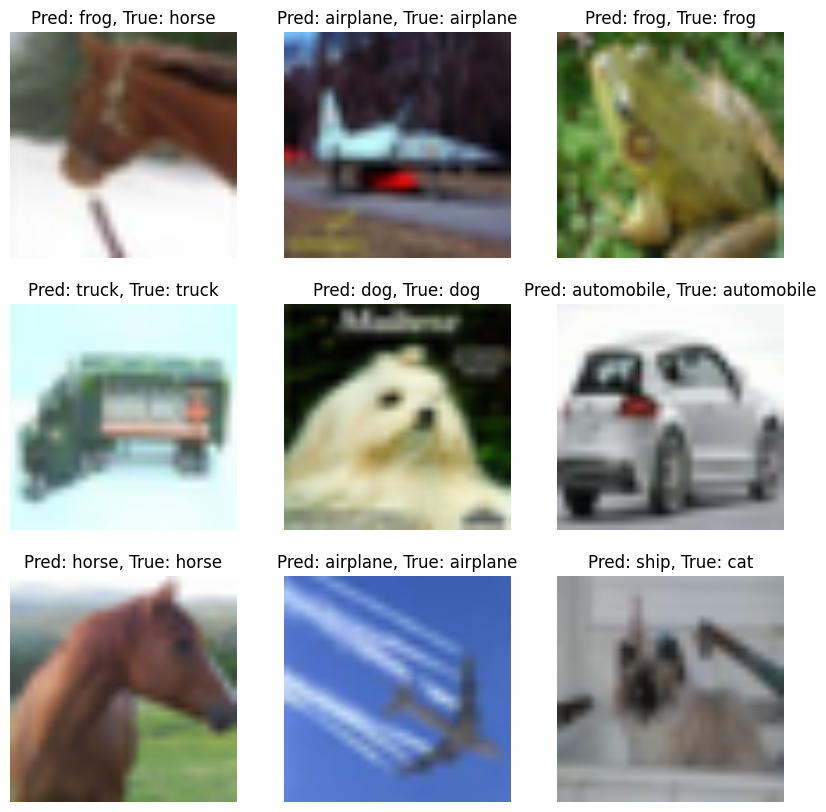

In [13]:
import matplotlib.pyplot as plt

# Function to plot test images and predictions
def plot_predictions(model, dataset):
    plt.figure(figsize=(10, 10))
    class_names = info.features['label'].names  # Class names in CIFAR-10
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Pred: {class_names[tf.argmax(predictions[i])]}, True: {class_names[labels[i]]}")
            plt.axis("off")

plot_predictions(model, test_ds)


## **Limitations:**
While our model performs well on CIFAR-10, limitations exist. Transfer learning using MobileNetV2 may not perfectly capture CIFAR-10’s class-specific details, as it was originally trained on ImageNet. Future improvements could involve fine-tuning, where some layers of MobileNetV2 are unfrozen and retrained on CIFAR-10, allowing the model to adapt better. Additionally, a larger model architecture could improve performance, but this would require more computational resources.

## **Conclusion:**
In this project, we saw how to classify images from the CIFAR-10 dataset using transfer learning with a pre-trained MobileNetV2 model. By utilizing this approach, we saved computation time and achieved reasonable accuracy on a multi-class dataset. This process showcases how neural networks can be effectively applied to computer vision tasks, even with more complex datasets like CIFAR-10.